# Hyperparameter testing for ANN

We start by importing the necessary libraries and setting the random seed for reproducibility.

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers.csv_logs import CSVLogger


In [13]:
seed = 78 # random seed, used for reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


We now download the dataset and prepare it before training

In [14]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),               # random crop for augmentation
    transforms.RandomHorizontalFlip(),                  # horizontal flip for augmentation
    transforms.ToTensor(),                              # convert to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465),      # normalize by mean and std per channel
                         (0.2470, 0.2435, 0.2616))      #These values come from "https://github.com/kuangliu/pytorch-cifar/issues/19" where the values for normalization were computed
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])


In [15]:
train_dataset = torchvision.datasets.CIFAR10(
    root='../.data',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='../.data',
    train=False,
    download=True,
    transform=transform_test
)

With both datasets separated, we can now create dataloaders for each dataset

In [16]:
BATCH_SIZE = 64

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Finally, we will use these loaders and datasets to train our ANN model.

In [ ]:
class LitANN(pl.LightningModule):
    def __init__(self, input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size//2)
        self.fc3 = nn.Linear(hidden_size//2, hidden_size//4)
        self.fc4 = nn.Linear(hidden_size//4, num_classes)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = x.view(x.size(0), -1)          # flatten for ANN
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc', acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_acc', acc, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=0.9)


In [21]:
import pytorch_lightning as pl

model = LitANN(input_size=32*32*3, hidden_size=128, num_classes=10, learning_rate=0.001)
csv_logger = CSVLogger("logs", name="ANN")
early_stop_callback = EarlyStopping(
    monitor='val_loss',   # or 'val_acc' if you log accuracy in validation_step
    min_delta=0.005,       # minimum change to count as improvement
    patience=5,           # how many validation epochs to wait for improvement
    verbose=True,
    mode='min'            # 'min' for loss, 'max' for accuracy
)

trainer = pl.Trainer(max_epochs=10, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 650    | train
----------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:18<00:00, 37.33it/s, v_num=3]

Metric val_loss improved. New best score: 1.897


Epoch 1: 100%|██████████| 704/704 [00:23<00:00, 30.31it/s, v_num=3]

Metric val_loss improved by 0.122 >= min_delta = 0.005. New best score: 1.776


Epoch 2: 100%|██████████| 704/704 [00:24<00:00, 28.74it/s, v_num=3]

Metric val_loss improved by 0.068 >= min_delta = 0.005. New best score: 1.707


Epoch 3: 100%|██████████| 704/704 [00:24<00:00, 29.25it/s, v_num=3]

Metric val_loss improved by 0.035 >= min_delta = 0.005. New best score: 1.672


Epoch 4: 100%|██████████| 704/704 [00:23<00:00, 29.85it/s, v_num=3]

Metric val_loss improved by 0.026 >= min_delta = 0.005. New best score: 1.647


Epoch 5: 100%|██████████| 704/704 [00:24<00:00, 28.94it/s, v_num=3]

Metric val_loss improved by 0.047 >= min_delta = 0.005. New best score: 1.599


Epoch 7: 100%|██████████| 704/704 [00:23<00:00, 30.03it/s, v_num=3]

Metric val_loss improved by 0.028 >= min_delta = 0.005. New best score: 1.571


Epoch 8: 100%|██████████| 704/704 [00:23<00:00, 29.64it/s, v_num=3]

Metric val_loss improved by 0.013 >= min_delta = 0.005. New best score: 1.558


Epoch 9: 100%|██████████| 704/704 [00:23<00:00, 29.67it/s, v_num=3]

Metric val_loss improved by 0.021 >= min_delta = 0.005. New best score: 1.538
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 704/704 [00:23<00:00, 29.65it/s, v_num=3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 158.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4625000059604645
        test_loss           1.5276494026184082
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5276494026184082, 'test_acc': 0.4625000059604645}]

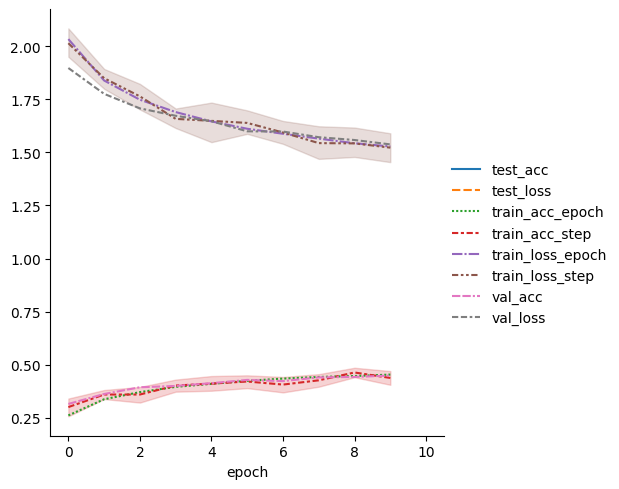

In [22]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

# Hyperparameters:
* Number of layers and units 
* Activation functions (ReLU, Sigmoid, Tanh, others)
* Optimizers (SGD, Adam, RMSprop) 
* Learning rate  - A
* Batch size - A
* Number of epochs  - A
* Weight initialization strategies (e.g., Xavier, He) 
* Dropout rate - A
* Batch Normalization (with vs without) 


Due to the need of a starting point, we started by using the parameters declared on the following link: https://www.chalisebibek.com.np/image-classification-with-pytorch-lightning-simple-ann. However, as we can see, the results are insatisfactory, which means that the hyperparameters need to be optimized. The current hyperparameters are not able to capture the complexity of the data. 

As stated before, due to the need of optimizing hyperparameters, we decided to increase the number of layers and continuing to funnel the number of neurons to try and prevent overfitting

In [23]:
trainer = pl.Trainer(max_epochs=10, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory logs\ANN\version_3\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 650    | train
----------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:14<00:00, 48.57it/s, v_num=3] 

Metric val_loss improved by 0.033 >= min_delta = 0.005. New best score: 1.505


Epoch 3: 100%|██████████| 704/704 [00:21<00:00, 32.49it/s, v_num=3]

Metric val_loss improved by 0.019 >= min_delta = 0.005. New best score: 1.486


Epoch 6: 100%|██████████| 704/704 [00:27<00:00, 25.56it/s, v_num=3]

Metric val_loss improved by 0.016 >= min_delta = 0.005. New best score: 1.469


Epoch 7: 100%|██████████| 704/704 [00:24<00:00, 28.91it/s, v_num=3]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.462


Epoch 8: 100%|██████████| 704/704 [00:23<00:00, 29.60it/s, v_num=3]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.455


Epoch 9: 100%|██████████| 704/704 [00:27<00:00, 25.68it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 704/704 [00:27<00:00, 25.66it/s, v_num=3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 171.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4957999885082245
        test_loss            1.434686303138733
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.434686303138733, 'test_acc': 0.4957999885082245}]

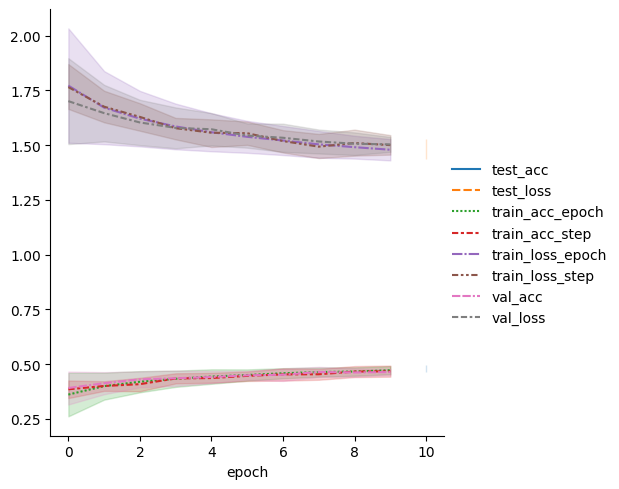

In [24]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

With the increase of the hidden layers, we can see that the accuracy and the loss both improved ever so slightly, without showing any signs of overfitting or underfitting. However, both metrics appear to be close to flatlining. So, in hopes of trying to discard the importance of the epochs, we tried to increase the number of epochs significantly and using early stopping with a min_delta of 0.005 to prevent overfitting. 


In [25]:
trainer = pl.Trainer(max_epochs=100, callbacks=[early_stop_callback], logger=csv_logger)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory logs\ANN\version_3\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | fc1  | Linear | 393 K  | train
1 | fc2  | Linear | 8.3 K  | train
2 | fc3  | Linear | 650    | train
----------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 704/704 [00:16<00:00, 42.46it/s, v_num=3] 

Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.445


Epoch 3: 100%|██████████| 704/704 [00:24<00:00, 28.79it/s, v_num=3]

Metric val_loss improved by 0.015 >= min_delta = 0.005. New best score: 1.430


Epoch 4: 100%|██████████| 704/704 [00:23<00:00, 30.21it/s, v_num=3]

Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.420


Epoch 5: 100%|██████████| 704/704 [00:22<00:00, 30.89it/s, v_num=3]

Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 1.414


Epoch 8: 100%|██████████| 704/704 [00:22<00:00, 30.70it/s, v_num=3]

Metric val_loss improved by 0.020 >= min_delta = 0.005. New best score: 1.394


Epoch 12: 100%|██████████| 704/704 [00:22<00:00, 30.73it/s, v_num=3]

Metric val_loss improved by 0.009 >= min_delta = 0.005. New best score: 1.385


Epoch 17: 100%|██████████| 704/704 [00:21<00:00, 32.04it/s, v_num=3]

Metric val_loss improved by 0.022 >= min_delta = 0.005. New best score: 1.363


Epoch 22: 100%|██████████| 704/704 [00:23<00:00, 30.08it/s, v_num=3]

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 1.355


Epoch 27: 100%|██████████| 704/704 [00:26<00:00, 26.20it/s, v_num=3]

Metric val_loss improved by 0.014 >= min_delta = 0.005. New best score: 1.342


Epoch 32: 100%|██████████| 704/704 [00:29<00:00, 23.97it/s, v_num=3]

Monitored metric val_loss did not improve in the last 5 records. Best score: 1.342. Signaling Trainer to stop.


Epoch 32: 100%|██████████| 704/704 [00:29<00:00, 23.95it/s, v_num=3]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\edmdu\Desktop\PG\FAP\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 113.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5157999992370605
        test_loss            1.359960913658142
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.359960913658142, 'test_acc': 0.5157999992370605}]

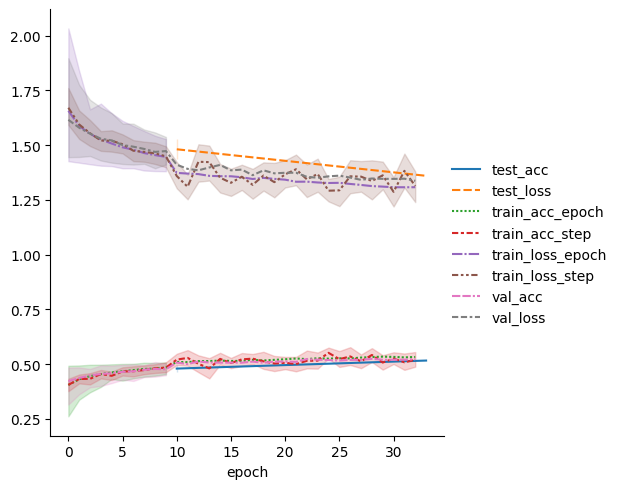

In [26]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")